In [7]:
# Load the Datasets
import torch
from torchvision import datasets, transforms, utils
import torchvision.utils as vutils
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [8]:
default_batch_size = 64

In [9]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transcform_cifar_norm = transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5)).to(default_device)
# TODO - add norm
transform_cifar = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True, num_workers=2)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# VAE Model Definition
class VAE_linear(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE_linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device))  # x2 for mean and variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
    
# VAE Loss function
def vae_loss_function(recon_x, x, mu, log_var, input_size):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

In [11]:
# VAE Training function
def train_vae_linear(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            inputs = Variable(inputs)

            # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            totalloss = BCE + KLD

            # Backward pass
            totalloss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), totalloss.item()))

In [12]:
# CIFAR 10 Data Training - Linear
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer
latent_size = 512 # Latent size for latent vector
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 1 # Number of epochs to train for

# Initialize the model
vae_model_cifar_linear = VAE_linear(input_size, hidden_size, latent_size)
# Optimizer
optimizer = optim.Adam(vae_model_cifar_linear.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_cifar_linear, trainloader_cifar, optimizer, num_epochs, input_size)

Epoch [1/1], Step [1/782], BCE: 136635.7500, KLD: 102.0987, Total Loss: 136737.8438
Epoch [1/1], Step [501/782], BCE: 126222.0547, KLD: 810.7463, Total Loss: 127032.8047


Original Images:


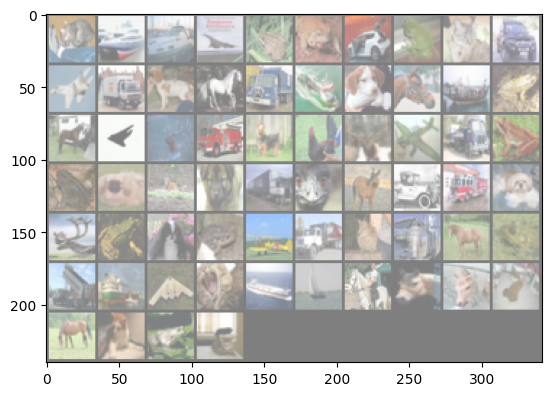

Reconstructed Images:


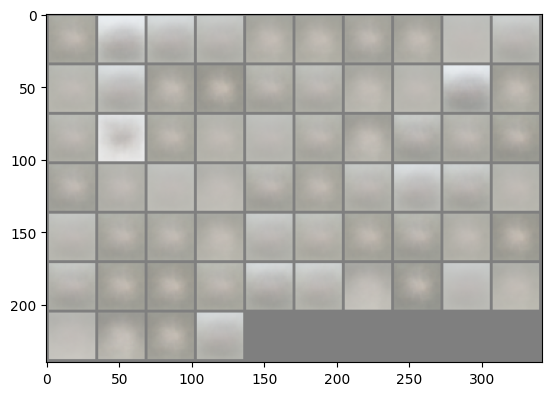

In [13]:
import torchvision

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to generate and display reconstructed images from the VAE
def generate_and_show_cifar_linear(vae_model, data_loader, num_rows=1):
    vae_model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            # Display original images
            print('Original Images:')
            imshow(torchvision.utils.make_grid(images, nrow=num_rows))

            # Forward pass through the VAE
            images = images.view(-1, 3 * 32 * 32).to(default_device)
            recon_images, _, _ = vae_model(images)

            # Reshape reconstructed images for visualization
            recon_images = recon_images.view(-1, 3, 32, 32)

            # Display reconstructed images
            print('Reconstructed Images:')
            imshow(torchvision.utils.make_grid(recon_images.cpu(), nrow=num_rows))
            break  # Break after the first batch for demonstration purposes



# Compare trained and untrained images
generate_and_show_cifar_linear(vae_model_cifar_linear, testloader_cifar, num_rows=10)